In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Jane Eyre, Bronte",45.049920,5.631240,12.847663,8
Azure Functions + Visual Studio,297.720878,59.544176,89.306116,5
Email Auth and Security,340.308928,42.538616,75.177392,8
Debugging in VS Code,602.568836,54.778985,99.694946,11
Logging in Python,735.441097,52.531507,124.025143,14
Azure AD Authentication,764.750305,58.826947,137.158981,13
Azure Private DNS,778.683834,40.983360,84.094105,19
RAG Project,900.606997,56.287937,114.587423,16
C# Basics,967.035087,31.194680,52.098011,31
VMWare,1063.622821,24.735414,36.261221,43


# Histogram

sum of ages: ~31708.96


<Axes: >

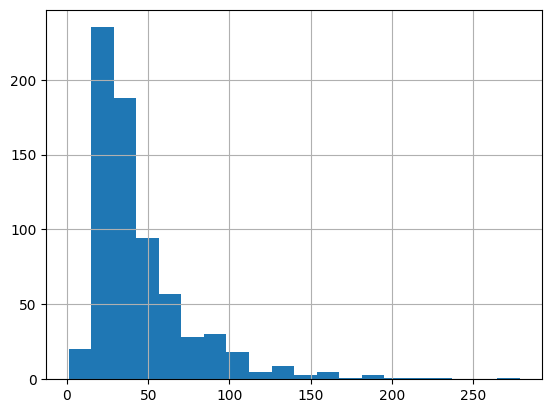

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [8]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [10]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [11]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 700
Total card age: 31708.96


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
165,Vocab,Do Androids Dream of Electric Sheep?\nThalamic...,6f6436ff34556183abf431b6d6ff4e9b,-129.915355,37.333,129.915355,-3658.63398,0.796768,0,0
166,Vocab,"Red Side Story, FForde\nCurtilage\nPronunciati...",2b0003d844a2f8f9f261119a9dafab69,-89.224952,37.333,129.915355,-3658.63398,0.796768,3,0
630,Vocab,Lost in a Good Book\nTunguska event: A massive...,3cb9bd04412deb4ebb1af74dd00b9c92,-81.310678,37.333,129.915355,-3658.63398,0.796768,6,0
632,Vocab,"Well of Lost Plots, Fforde\nMemsahib\nnoun | M...",c38254a62224bc9998e906ef00f2e77f,-70.118217,37.333,129.915355,-3658.63398,0.796768,9,0
169,Vocab,How to Sell a Haunted House\nGethsemane\nPronu...,ad0a3881ba248d4e088cf142e324f551,-69.015489,37.333,129.915355,-3658.63398,0.796768,12,0
170,Vocab,"Red Side Story, FForde\nGimbal\nPronunciation:...",687b7033287bb606e2e1ee1052b33618,-61.566523,37.333,129.915355,-3658.63398,0.796768,15,0
171,Vocab,"Well of Lost Plots, Fforde\nTabula rasa\nnoun ...",12272c6b1494f8d10a923f0a2fbedebd,-51.347265,37.333,129.915355,-3658.63398,0.796768,18,0
635,Vocab,Interval Funds May Provide Higher Yields and D...,523da2999fba3d1a6b95e67c3da83c23,-49.731218,37.333,129.915355,-3658.63398,0.796768,21,0
173,Vocab,Structured Credit Carries Complexity and Risk:...,d1ddeb2102d877f18a1691442556fcdb,-46.023369,37.333,129.915355,-3658.63398,0.796768,24,0
174,Vocab,"Red Side Story, FForde\nProscenium\nPronunciat...",0a777acbd31f5de1da6c3418625c21b6,-39.753505,37.333,129.915355,-3658.63398,0.796768,27,0


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [14]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [15]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [17]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
121,Azure Developer Associate,What are the two primary data types collected ...,f0995a4e3eae52ece78cb2f025efcf7f,-278.634360,48.521720,278.634360,-3542.085539,0.872469,0,0
5,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,-232.745971,57.704046,232.745971,-1211.784960,0.346259,0,0
360,Azure Developer Associate,Which role grants least privilege to allow a u...,72ce544617e81069d717793d0c83d443,-217.220105,48.521720,278.634360,-3542.085539,0.872469,1,1
33,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,-207.995966,53.983502,207.995966,-3239.010110,0.798849,0,0
248,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f4ebac7aac964a3452e1734f5f37fcea,-192.831798,57.704046,232.745971,-1211.784960,0.346259,1,1
275,PnP PowerShell,System.IO.Stream (System.IO)\nRepresents a seq...,3f146f4a53f3f36ced6256f3cfc16375,-189.848383,53.983502,207.995966,-3239.010110,0.798849,1,1
18,Python,Q:\nWhat are the two essential methods that an...,558bcbe4e40c504fe6e977eb903fb48d,-183.479129,56.648071,183.479129,-1812.738270,0.685970,0,0
589,Azure Developer Associate,How does the Always restart policy differ from...,0858a8d05dbc45117b3d0f1dd538772b,-172.040243,48.521720,278.634360,-3542.085539,0.872469,2,2
105,Asynchronous Python,Lock (Mutex)\nA lock is a synchronization prim...,2218c022e468947a8bbd7ec0626cfe1e,-165.573550,47.700757,165.573550,-2194.234826,0.539736,0,0
122,Azure Developer Associate,What Azure Monitor feature routes platform log...,5208880711caac6907d82731a1e43cd9,-164.358384,48.521720,278.634360,-3542.085539,0.872469,3,0


In [18]:
existing_cards.head(10).sum()

head                   VocabVocabVocabVocabVocabVocabVocabVocabVocabV...
body                   Do Androids Dream of Electric Sheep?\nThalamic...
hash                   6f6436ff34556183abf431b6d6ff4e9b2b0003d844a2f8...
age                                                          -688.006572
subject_mean_age                                              373.329998
subject_highest_age                                          1299.153551
subject_age_sum                                            -36586.339805
head_random_roll                                                7.967681
count                                                                135
n_fold                                                                 0
dtype: object

In [19]:
existing_cards['age'].mean()

-45.298521106419834